
## Before your start:

   - Read the README.md file
   - Comment as much as you can and use the resources in the README.md file
   - Happy learning!



# Image Segmentation

**Image Segmentation** is an image analysis task in which we classify each pixel in the image into a class. This is similar to what us humans do all the time by default. 

What’s the first thing you do when you’re attempting to cross the road?

We typically look left and right, take stock of the vehicles on the road, and make our decision. Our brain is able to analyze, in a matter of milliseconds, what kind of vehicle (car, bus, truck, auto, etc.) is coming towards us. Whenever we are looking at something, then we try to “segment” what portion of the image belongs to which class/label/category.

![test](images/test.jpeg)

## So how does image segmentation work?

We can divide or partition the image into various parts called segments. It’s not a great idea to process the entire image at the same time as there will be regions in the image which do not contain any information. By dividing the image into segments, we can make use of the important segments for processing the image. That, in a nutshell, is how image segmentation works.

An image is a collection or set of different pixels. We group together the pixels that have similar attributes using image segmentation. 

**Sooner or later all things are numbers, including images.**

In [1]:
# Install torch & torchvision, it might take some time

#!pip3 install torch
#!pip3 install torchvision
#!pip3 install pillow

In [2]:
# Import your libraries

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.signal
from imageProcessing import resizeImg, generateMask
import torch
from torchvision import models
import torchvision.transforms as tt

## Challenge 1 - Load a picture & let the magic begin!


In order to be able to segment an image, what **we first need is an image**. So, first thing you should do is loading one of yourself. Use [`Image.open`](https://pillow.readthedocs.io/en/3.1.x/reference/Image.html) for this purpose and call `img` to this variable. (In case you don't want to use your own image you can use one located at `images/bird.png`.

Using this function you will be using Pillow, the most popular and de facto standard library in Python for loading and working with image data. However, if you'd like to see how gorgeous you look on that picture, try using [`plt.show`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.show.html).

In [3]:
!ls images

bird.png	 EVCuCvFXYAIc3Ea.png  perritorgb.png
blured_bird.JPG  ironhack.png	      test.jpeg


(2000, 1500)


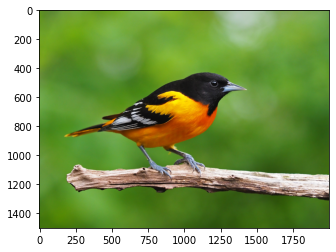

In [4]:
# Your code here

img = Image.open('images/bird.png')
print(img.size)
plt.imshow(img)

Sometimes it is desirable to thumbnail all images to have the same width or height. In this case, the width, will be reduced to 256, using `resizeImg`, and the height will be scaled in order to retain the aspect ratio of the image.

*Hint: use `img.size` as much as you need until you get a size of (384, 256)*.

(384, 256)


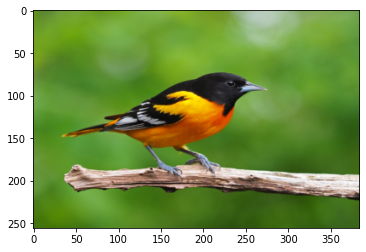

In [5]:
# Your code here
thumb = resizeImg(img, dimension=(256,384))
print(thumb.size)
plt.imshow(thumb)

But, don't worry! This time won't be that difficult, you get some code to make your life easier.
Here the function `generateMask`, as you may imagine, will generate a [`mask`](http://www.xinapse.com/Manual/masking.html) for the picture you loaded. One for the background of the picture, one for the foreground. 

# Making a mask with a Forward Convolutional Network
Inputs require an image and a network

Normalizes by using the `mean` and the `std`, and `tt.Compose` `torchvision.transforms`


Outputs a decoded segmap


In [6]:
# https://pytorch.org/hub/pytorch_vision_fcn_resnet101/
print('Setting up ResNet 101')
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()
net=fcn

# Set Transform parameters
#torchvision transforms compose : h
trf = tt.Compose([tt.ToTensor(), 
               tt.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])

'ResNet 101 Defined, and tensor transform is prepared with default settings from docs'

Setting up ResNet 101


'ResNet 101 Defined, and tensor transform is prepared with default settings from docs'

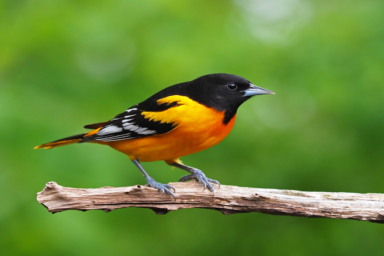

In [7]:
thumb  # ♠ OPTIMIZATION: PIL Image thumbnail, I used to be using the full size image
       #  and that was giving me trouble, capping my RAM and killing the kernel.

### This PIL image will be transformed into a tensor which is compatible with the ResNEt 101 we just configured

In [8]:
print('The tochvision.transforsm using the tt.Compose() class instanciation:')
print(trf.transforms) 

# Preparing the input
inp_pre = trf(thumb)
print('\n\nAnd this is our tensor image, once loaded')
print(f"inp_pre.size():    {inp_pre.size()}")

print(type(inp_pre))
inp_pre

The tochvision.transforsm using the tt.Compose() class instanciation:
[ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]


And this is our tensor image, once loaded
inp_pre.size():    torch.Size([3, 256, 384])
<class 'torch.Tensor'>


tensor([[[-0.4568, -0.4739, -0.4911,  ..., -0.2513, -0.2684, -0.3027],
         [-0.4226, -0.4397, -0.4568,  ..., -0.2342, -0.2513, -0.2856],
         [-0.4397, -0.4397, -0.4911,  ..., -0.2684, -0.2684, -0.2684],
         ...,
         [-0.9877, -1.0219, -1.0219,  ..., -1.1247, -1.1075, -1.0904],
         [-1.0048, -1.0048, -0.9877,  ..., -1.1418, -1.1075, -1.1075],
         [-1.0048, -1.0219, -1.0219,  ..., -1.1589, -1.1075, -1.1075]],

        [[ 0.5553,  0.5378,  0.5028,  ...,  0.7304,  0.7129,  0.7129],
         [ 0.5553,  0.5378,  0.5028,  ...,  0.7479,  0.7304,  0.7304],
         [ 0.5728,  0.5378,  0.5028,  ...,  0.7654,  0.7654,  0.7304],
         ...,
         [-0.0399, -0.0224, -0.0049,  ..., -0.2500, -0.2500, -0.2325],
         [-0.0224, -0.0224, -0.0224,  ..., -0.2500, -0.2500, -0.2325],
         [-0.0224, -0.0224, -0.0224,  ..., -0.2675, -0.2500, -0.2500]],

        [[-1.2293, -1.2119, -1.1944,  ..., -0.4450, -0.4798, -0.4973],
         [-1.2293, -1.1770, -1.1770,  ..., -0

In [9]:
print("This is the Unsqueeze")
inp = trf(thumb).unsqueeze(0)
print(inp.size())
print(type(inp))

This is the Unsqueeze
torch.Size([1, 3, 256, 384])
<class 'torch.Tensor'>


In [10]:
print(f"inp.size():    {inp.size()}")
print(inp)

#print(inp.size())

inp.size():    torch.Size([1, 3, 256, 384])
tensor([[[[-0.4568, -0.4739, -0.4911,  ..., -0.2513, -0.2684, -0.3027],
          [-0.4226, -0.4397, -0.4568,  ..., -0.2342, -0.2513, -0.2856],
          [-0.4397, -0.4397, -0.4911,  ..., -0.2684, -0.2684, -0.2684],
          ...,
          [-0.9877, -1.0219, -1.0219,  ..., -1.1247, -1.1075, -1.0904],
          [-1.0048, -1.0048, -0.9877,  ..., -1.1418, -1.1075, -1.1075],
          [-1.0048, -1.0219, -1.0219,  ..., -1.1589, -1.1075, -1.1075]],

         [[ 0.5553,  0.5378,  0.5028,  ...,  0.7304,  0.7129,  0.7129],
          [ 0.5553,  0.5378,  0.5028,  ...,  0.7479,  0.7304,  0.7304],
          [ 0.5728,  0.5378,  0.5028,  ...,  0.7654,  0.7654,  0.7304],
          ...,
          [-0.0399, -0.0224, -0.0049,  ..., -0.2500, -0.2500, -0.2325],
          [-0.0224, -0.0224, -0.0224,  ..., -0.2500, -0.2500, -0.2325],
          [-0.0224, -0.0224, -0.0224,  ..., -0.2675, -0.2500, -0.2500]],

         [[-1.2293, -1.2119, -1.1944,  ..., -0.4450, -0.47

In [11]:
out = net(inp)['out']

### The output has been labeled on the second dimension of the tensor

In [12]:
out.shape 

torch.Size([1, 21, 256, 384])

In [13]:
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print(om.size,  om.shape, type(om)) 
om

98304 (256, 384) <class 'numpy.ndarray'>


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# DECODE SEGMAP

Takes in an `image` and an `nc` as inputs.

Returns a `rgb` = `np.stack([r, g, b], axis=2)`

In [14]:
#rgb = decode_segmap(om)
#RGB OUT

In [15]:
mask = generateMask(thumb)

In [16]:
def decode_segmap(image, nc=21):
    """Takes in an image and an NC"""
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane,   2=bicycle,        3=bird,            4=boat,            5=bottle
               (128, 0, 0),     (0, 128, 0),    (128, 128, 0),     (0, 0, 128),       (128, 0, 128),

                 # 6=bus,            7=car,             8=cat,         9=chair,          10=cow
               (0, 128, 128), (128, 128, 128),      (64, 0, 0),      (192, 0, 0),      (64, 128, 0),
            
              # 11=dining table,    12=dog,           13=horse,       14=motorbike,     15=person
               (192, 128, 0),    (64, 0, 128),      (192, 0, 128),   (64, 128, 128),  (192, 128, 128),
 
             # 16=potted plant,       17=sheep,          18=sofa,       19=train,       20=tv/monitor
               (0, 64, 0),         (128, 64, 0),      (0, 192, 0),   (128, 192, 0),   (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [17]:
background_mask = np.all(mask == [0, 0, 0], axis=-1)
foreground_mask = np.any(mask != [0, 0, 0], axis=-1)
foreground_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

### Checking out the resulting masks

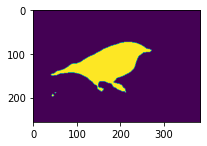

In [18]:
plt.figure(figsize=(3,3))
plt.imshow(foreground_mask)

Now it's your turn again, convert the image to np.array and apply the mask twice to the picture, once to the `foreground` and once to the `background`. Make a couple of copies of the image instead of assigning the same value to different variables. After doing this, you may want to check how those are looking. 

In [19]:
# Your code here
thumb_arr = np.array(thumb)
print(thumb_arr.shape)

#Old method - 
#rgb_msks= {}
#for l in range(3):
    #rgb_msks[f'foreground_mask{l}'] = thumb_arr[:,:,l]* foreground_mask
    #rgb_msks[f'background_mask{l}'] = thumb_arr[:,:,l]* background_mask

(256, 384, 3)


In [53]:
def generateImgContainer(img_ndarray):
    # Make an empty collection to store the foreground color arrays
    rgb_msks= {'fore': {},
               'back': {}
              }
    for key in ['fore', 'back']:
        for l in range(3):  # Saving each layer in the correct collection
            if key == 'fore':
                data = { l : thumb_arr[:,:,l] * background_mask} # What we will be storing in the collection
            elif key == 'back':
                data = { l : thumb_arr[:,:,l] * foreground_mask} 
            rgb_msks[key].update(data)
    print(rgb_msks[key].keys())
    return rgb_msks

rgb_msks = generateImgContainer(thumb_arr)

dict_keys([0, 1, 2])


# All possible combinations

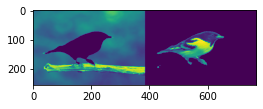

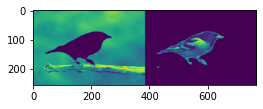

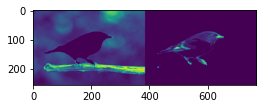

In [54]:
for l in range(3):
    plt.figure(figsize=(4,8))
    plt.imshow(np.concatenate((rgb_msks['fore'][l],
                               rgb_msks['back'][l]), axis=1))

## Challenge 2 - Two 2-dimensional arrays, one channel

Convolution involving one-dimensional signals is referred to as 1D convolution or just convolution. Otherwise, if the convolution is performed between two signals spanning along two mutually perpendicular dimensions (i.e., if signals are two-dimensional in nature), then it will be referred to as [`2D convolution`](http://www.songho.ca/dsp/convolution/convolution2d_example.html). 

This kind of operation is extensively used in the field of digital image processing, such as smoothing, sharpening, and edge detection of images. Wherein the 2D matrix representing the image will be convolved with a comparatively smaller matrix called 2D kernel. 

[*What do you mean by one channel?*](https://brohrer.github.io/convert_rgb_to_grayscale.html)

Color images are represented as three-dimensional Numpy arrays - a collection of three two-dimensional arrays, one each for red, green, and blue channels. Each one, like grayscale arrays, has one value per pixel and their ranges are identical. 

An intuitive way to convert a color image 3D array to a grayscale 2D array is, for each pixel, take the average of the red, green, and blue pixel values to get the grayscale value. This combines the lightness or luminance contributed by each color band into a reasonable gray approximation. 

<img src="images/perritorgb.png" width="500">





#### First let's begin with black and white (only one channel)

Transform `foreground` and `background`, now they are arrays, to an image and convert them in gray scale. Name them `fore_bnw` and `back_bnw` respectively.

*Hint: use `.fromarray` and then `.convert`*.

In [55]:
rgb_msks.keys() # The masks, each include a layer for each color channel (RGB)

dict_keys(['fore', 'back'])

Here I create a generator to output the layers in my image

In [56]:
"""def grayscaler(dictionary):
    dimensions = []
    for a in dictionary.values():
        dimensions.append(np.array(a))
    return np.array(dimensions)"""

'def grayscaler(dictionary):\n    dimensions = []\n    for a in dictionary.values():\n        dimensions.append(np.array(a))\n    return np.array(dimensions)'

In [57]:
"""print(f"INPUT: {type(rgb_msks)}")
grays_together = grayscaler(rgb_msks)

print('\n printing grays_together, which is an np array with the dimensions of the input dictionary')
print('type(grays_together)', type(grays_together))"""

'print(f"INPUT: {type(rgb_msks)}")\ngrays_together = grayscaler(rgb_msks)\n\nprint(\'\n printing grays_together, which is an np array with the dimensions of the input dictionary\')\nprint(\'type(grays_together)\', type(grays_together))'

Show `fore_bnw` and `back_bnw` in order to check that they are in a gray scale.

### How many color in my dict?: 
#### 3 colors (RGB), and 2 masks (foreground and background)
Be careful when using the `Image.fromarray(np.uint8(data))`, the input must be uint8 to be decoded correctly

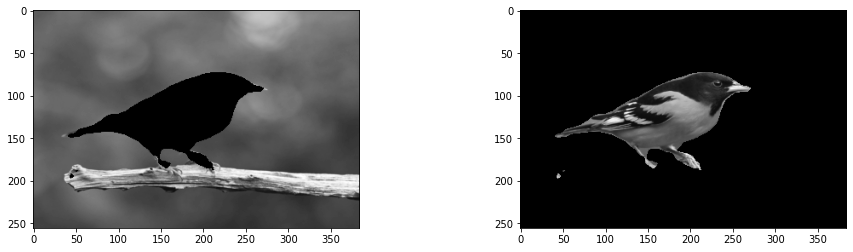

In [58]:
def nparr_to_PIL(dictionary):
    image_means = np.uint8(())
    for i in range(0, (len(dictionary))//2):  # print the available composite images
        config = rgb_msks['fore'][i] + rgb_msks['back'][i] # print the complete image        
        
        if True: # Switch to output the correct config (Try to switch between True and False)
            config = np.uint8((dictionary[0],
                               dictionary[1],
                               dictionary[2],)).mean(axis=0) # 
        #print(config)
        img = Image.fromarray(np.uint8(config))
    return img
#        image_means += fore_bnw

back_bnw = nparr_to_PIL(rgb_msks['fore'])
fore_bnw = nparr_to_PIL(rgb_msks['back'])
#print(type(fore_bnw), fore_bnw.size, fore_bnw.mode, fore_bnw.info)
f,a= plt.subplots(1,2, figsize=(16,4))

a[0].imshow(back_bnw, cmap='gray')
a[1].imshow(fore_bnw, cmap='gray')

Now transform `back_bnw` into an array and name it `back_np`.

In [79]:
back_np = np.array(back_bnw)
fore_np = np.array(fore_bnw)

And create a 2d matrix with random values of size 20x20 uniformly distributed and name it `kernel`.

In [60]:
# ♠ - Here i make a random kernel function for future use: 
# Maybe set up a seed to fix the randomness
def rand_kernel(x,y):
    kernel = np.zeros((x,y))
    for r in range(x):
        for c in range(y):
            kernel[r][c] += np.random.random()
    return kernel 
kernel = rand_kernel(20,20)
kernel.mean(), kernel.size, kernel.shape

(0.46067235821334895, 400, (20, 20))

Now you must use `signal.convolve2d` from scipy and pass the array image (`back_np`) and the kernel as parameters. [Check the docs for `convolve2d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html) and assign it to a variable called `conv`.

*Hint: use mode='same' in order to get an array with the same size as the input one.*

(256, 384) 0.0 40864.30887868045 <class 'numpy.ndarray'>


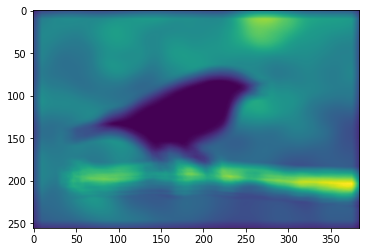

In [88]:
# Your code here
convolute = scipy.signal.convolve2d
conv = convolute(back_np, kernel, mode='same')
plt.imshow(conv)
print(conv.shape, conv.min(), conv.max(), type(conv))

Now you must operate with `conv` in order to have their values between 0 and 255.

In [96]:
#Normalizing the 2d array
norm =  (conv /conv.max())*255
norm.min(), norm.max(), norm.mean()

(0.0, 255.0, 99.15280517953335)

Apply `.absolute` from numpy to the new value of `conv` and assign it to `back_blur`, and if you show this `back_blur` you will notice that the blur effect has been apply to the background.

In [29]:
# Your code here

Finally, create a new variable called `final` which have `back_blur` and `fore_bnw` arrays using the `.add` function.

Make sure the type of the output is `np.uint8`, else use the `.astype` function. Show `final`.

In [30]:
# Your code here

## Challenge 3 -  Once wasn't enough, do it three times

**aquí es donde la matan**
-Marc Pomar

Define a `def blur(img): ...` function which blurs an image having RGB channels. To do this:
1. Using numpy generate a 2d matrix with random values of size 20x20 uniformly distributed. We call this the `kernel`.  
2. Use `signal.convolve2d` from scipy and pass the image and the kernel as parameters.[Check the docs for `convolve2d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html)
3. Check the output values and ensure data is in range 0-255. *Hint: Divide the output array by max value.*

Make sure the type of the output is `np.uint8`.

In [31]:
# Your code here
thb_ar = np.array(thumb)


Once you have demonstrated you are a great coder defining the `blur` function. It's time for you to check if it works, bluring the background of the `background` image.

In [32]:
# Your code here

Apply the `foreground_mask` again. 

In [33]:
# Your code here

Sum the blured background and the original foreground using [`np.add`](https://numpy.org/doc/1.18/reference/generated/numpy.add.html).

In [34]:
# Your code here

Finally, once you've got something like the picture below, please, export that **Image**. Make sure you add this result and all of those you generate to the Pull Request.

<img src="images/bird.png" width="300">
<img src="images/blured_bird.JPG" width="300">

In [35]:
# Your code here

## Enjoy your weekend!